In [1]:
%load_ext pycodestyle_magic

In [2]:
%flake8_on

# PROJET 5 : Catégorisation automatiquement des questions

## SOMMAIRE  <a class="anchor" id="sommaire"></a>
## [CONTEXTE DU PROJET](#1)<a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#3)<a class="anchor" id="sommaire"></a>

## [MISSION 3: PREPROCESSING](#11)<a class="anchor" id="sommaire"></a>
### [M3-1 : Préparation des input et output : ](#12)<a class="anchor" id="sommaire"></a>
### [M3-2 : Séparation de jeu de données de test et d'entrainement : ](#13)<a class="anchor" id="sommaire"></a>

## [MISSION 4: APPROCHE NON-SUPERVISEE](#15)<a class="anchor" id="sommaire"></a>
### [M4-1 : Modélisation avec algorithme LDA : ](#16)<a class="anchor" id="sommaire"></a>
### [M5-1 : Modélisation avec algorithme NMF : ](#17)<a class="anchor" id="sommaire"></a>

## [MISSION 5: APPROCHE SUPERVISEE](#20)<a class="anchor" id="sommaire"></a>


--------------------------------------------------------

## [CONTEXTE DU PROJET](#sommaire)<a class="anchor" id="1"></a>

Stack Overflow est un site de questions-réponses liées au développement informatique.
Les tags nous permettent de retrouver facilement la réponse à une question posée, pourtant ce n'est pas évident de trouver des tags associés à notre question.
Donc il était intéressant de développer un application qui suggererait automatiquement plusieurs tags pertinents à partir d'une question posée. 

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
import os
import re
import warnings
import pyLDAvis.gensim
import pickle, requests, json
from time import time
from utils.functions import custom_tokenize, print_top_words
from utils.functions import predictTag, vectorizeInputTest
from utils.functions import remove_stopword, cleanText, pattern_searcher
from utils.functions import compute_coherence_values, print_topics
from nltk.stem import WordNetLemmatizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from sklearn.decomposition import NMF
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, jaccard_score
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.dummy import DummyClassifier

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
11:14: E401 multiple imports on one line


In [4]:
# Configuration affichage
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## [MISSION 3: PREPROCESSING](#sommaire)<a class="anchor" id="11"></a>

#### Récuperation des données texte :

Exportons les données stockées dans des fichiers texte :

- data/tags_words_tokens.csv : contient les données de base
- data/Backup/top1000_words.csv : contient les données de top 1000 des mots 
- data/Backup/top100_tags.csv : contient les données de top 100 des tags
- data/Backup/X_data.csv
- data/Backup/y_data.csv

In [5]:
data_preprocess = pd.read_csv('data/Backup/tags_words_tokens.csv',
                              sep='\t', engine='python')
data_preprocess.drop(['Unnamed: 0'], axis=1, inplace=True)

top1000words_exp = pd.read_csv('data/Backup/top1000_words.csv',
                               header=None, index_col=0,
                               squeeze=True).to_dict()
top100tags_exp = pd.read_csv('data/Backup/top100_tags.csv',
                             header=None, index_col=0,
                             squeeze=True).to_dict()

### [M3-1 : Préparation des input et output : ](#sommaire)<a class="anchor" id="12"></a>

#### vectorisation de corpus par Bag Of Words:

In [6]:
# Corpus (=X) en entrée on aura un ensmble de mots -> Body + Title
X_data = pd.read_csv('data/Backup/X_data.csv', sep='\t', engine='python')
X_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
# X_data

#### vectorisation des tags par MultiLabelBinarizer :

In [8]:
# 4.1 Tags (=y)
y_data = pd.read_csv('data/Backup/y_data.csv', sep='\t', engine='python')
y_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
# y_data

Le resultat est une matrice de (8292, 100) car nous avons 8292 lignes et 100 (tags) nouvelles colonnes.

### [M3-2 : Séparation de jeu de données de test et d'entrainement : ](#sommaire)<a class="anchor" id="13"></a>

Nous allons utiliser 80% des données pour l'entrainement et 20% pour le test

In [10]:
# Split train and test :
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1)

## [MISSION 4: APPROCHE NON-SUPERVISEE](#sommaire)<a class="anchor" id="15"></a>

In [19]:
n_samples = 0.8
n_features = 1000
n_components = 20
n_top_words = 20
data_preprocess_copy = cleanText(data_preprocess)
data_preprocess_copy.drop(['tokens', 'tokensStopWord'], axis=1, inplace=True)
corpus = data_preprocess_copy['words_tokens']
tags = data_preprocess_copy['tags_tokens']
datasetX = corpus.tolist()
datasety = tags.tolist()

X_trainBis = datasetX[:int(len(datasetX)*n_samples)]
y_trainBis = datasety[:int(len(datasety)*n_samples)]
X_testBis = datasetX[int(len(datasetX)*n_samples):]
y_testBis = datasety[int(len(datasety)*n_samples):]


def dummy(doc):
    return doc

### [M4-1 : Modélisation avec algorithme LDA : ](#sommaire)<a class="anchor" id="16"></a>

LDA (Latent Dirichlet Allocation) est un modèle probabiliste génératif avec les hypothèses suivantes : 

•	Chaque question du corpus est un ensemble de mots sans ordre (bag-of-words) ;

•	Chaque question m aborde un certain nombre de topic dans différentes proportions qui lui sont propres p(θm) ;

•	Chaque mot possède une distribution associée à chaque topic p(ϕk) . On peut ainsi représenter chaque topic par une 
probabilité sur chaque mot.

•	 zn représente le topic du mot wn


In [20]:
print("Vectorisation et entrainement du modèle pour LDA...")

tfidf_vectorizer_lda = CountVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       tokenizer=dummy, preprocessor=dummy,
                                       analyzer='word')
tfidf_lda = tfidf_vectorizer_lda.fit_transform(X_trainBis)

# entrainer le modèle :
lda = LDA(n_components=n_components, n_jobs=-1)
lda.fit(tfidf_lda)

Vectorisation et entrainement du modèle pour LDA...


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

#### La recherche de nombre de topics optimal :

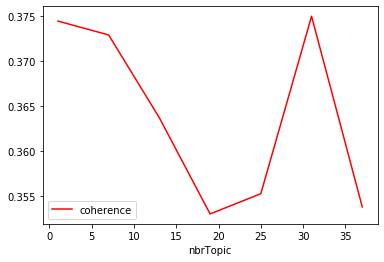

<Figure size 1440x720 with 0 Axes>

In [21]:
# Calcul de coherence_score avec (4,6,8,10,12 topics) :
outputCoherence = pd.DataFrame(columns=['nbrTopic', 'coherence'])

dictionary = Dictionary(datasetX)
id2word = Dictionary(corpus)
corpus_copy = corpus.copy()
corpus_copy = [dictionary.doc2bow(doc) for doc in corpus_copy]

for i in range(1, 42, 6):
    number_topics = i
    ldai = LdaMulticore(corpus_copy, id2word=id2word, num_topics=number_topics)
    coherence_model_ldai = CoherenceModel(model=ldai, texts=corpus,
                                          dictionary=dictionary,
                                          coherence='c_v')
    coherence_ldai = coherence_model_ldai.get_coherence()
    dictionarylda = {"nbrTopic": number_topics,
                     "coherence": coherence_ldai}
    outputCoherence = outputCoherence.append(dictionarylda, ignore_index=True)
# outputCoherence.head(10)
# Representation graphique de coherence
ax = plt.gca()
outputCoherence.plot(kind='line', x='nbrTopic',
                     y='coherence', color='red', ax=ax)
plt.figure(figsize=(20, 10))
plt.show()

Donc on voit que le nombre de topics optimal serait 30 , donc on gardera 30 topics.   

In [22]:
# Representation graphique des 20 topics :
# pyLDAvis nous permet de visualiser les résultats de LDA interractif.

from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
LDAvis_prepared = sklearn_lda.prepare(lda, tfidf_lda,
                                      tfidf_vectorizer_lda, R=n_top_words)
pyLDAvis.display(LDAvis_prepared)

Sur le côté gauche, la zone de chaque cercle représente l'importance du topic par rapport au corpus. 

Comme il y a 6 topics, nous avons 6 cercles.
La distance entre le centre des cercles indique la similitude entre les sujets. 
Ici, les topics qui se chevauchentont donc des sujets plus similaires.

Sur le côté droit, l' histogramme de chaque topic montre les 10 mots les plus pertinents . 
Par exemple, dans le topic 1, les mots les plus pertinents sont file, use, object, like, ...

In [23]:
# La liste des topics trouvées par le modèle LDA
print("Les topics touvées via LDA:")
print_topics(lda, tfidf_vectorizer_lda, n_top_words)

Les topics touvées via LDA:
Topic # 0:
c++ type std template int operator char pointer node const include class npm member vector use struct compiler return using
Topic # 1:
android activity button device screen xml item phone layout_height= layout_width= wrap_content textview id= intent +id fill_parent layout dialog linearlayout programmatically
Topic # 2:
int error origin remote push integer random feature master size ref main printf float sum code bit long hidden number
Topic # 3:
method view class use model like would way controller one call want object pattern dont property make using need interface
Topic # 4:
window run error server application running process work get module using command set program tried code ive linux file message
Topic # 5:
function var javascript option return time code call alert second work value get false value= result like using way argument
Topic # 6:
string number like character would way line time two want space one point example word using expressio

### [M5-1 : Modélisation avec algorithme NMF : ](#sommaire)<a class="anchor" id="17"></a>

**NMF**(Non-Negative Matrix Factorization)est aussi une technique non supervisée,C'est une alyernative au LDA

In [24]:
# Use tf-idf features for NMF.
print("Extraction des features pour NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   tokenizer=dummy,
                                   preprocessor=dummy)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(X_trainBis)
tfidf_test = tfidf_vectorizer.transform(X_testBis)
print("fait en %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fit de modele NMF (Frobenius norm) avec tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("fait en %0.3fs." % (time() - t0))

print("\nLes Topics dans NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Extraction des features pour NMF...
fait en 1.171s.
Fit de modele NMF (Frobenius norm) avec tf-idf features, n_samples=0 and n_features=1000...
fait en 4.926s.

Les Topics dans NMF model (Frobenius norm):
Topic #0: use would like code one know using way ive question time work example dont java used need project application make
Topic #1: file directory folder path open using find want filename read project download batch content include extension import upload need way
Topic #2: git branch commit repository master remote change push commits merge origin pull local repo github head clone checkout project svn
Topic #3: string convert character java str way byte char return hello split replace like remove text space integer new int check
Topic #4: difference whats one two vs. use explain java please someone used different understand term example main programming performance operator know
Topic #5: table sql database mysql column select row query server name insert join null statement coun

Sur les differents topics résultants de NMF ici, on peut facilement deduire visuellement par exemple que :
 - le topic 2 parle de gestion de versionning de projet
 - le topic 5 parle de base des données

### Calcul des scores de performances pour LDA et NMF :

Pour mesurer la similarité entre la prédiction des modèles et les vrais tags, nous allons utiliser la cosine_simularity, elle permet de quantifier la ressemblance entre deux vecteurs(vecteurs des tags de prédictions et vecteurs des vrais tags)

La cosine_simularity est une valeur comprise dans l'intervalle [-1,1], 

 - -1 indiquera des vecteurs opposés, 
 
 - 0 des vecteurs indépendants  

 - 1 des vecteurs similaires 

In [25]:
# calcul de cosine_simularity :
# Pour LDA :
doc_term_matrix_lda = tfidf_lda.todense()
df_predict_lda = pd.DataFrame(doc_term_matrix_lda,
                              columns=tfidf_vectorizer_lda.get_feature_names())
cs_lda = cosine_similarity(df_predict_lda, X_test)

# Pour NMF :
doc_term_matrix_nmf = tfidf.todense()
df_predict_nmf = pd.DataFrame(doc_term_matrix_nmf,
                              columns=tfidf_vectorizer.get_feature_names())
cs_nmf = cosine_similarity(df_predict_nmf, X_test)

# Calcul de DummyClassifier
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_trainBis, y_trainBis)

print("DummyClassifier score  : {}".format(clf.score(X_testBis, y_testBis)))
print("Cosine_simularity score LDA : {}".format(np.mean(cs_lda)))
print("Cosine_simularity score NMF : {}".format(np.mean(cs_nmf)))

DummyClassifier score  : 0.004810126582278481
Cosine_simularity score LDA : 0.016174398111016484
Cosine_simularity score NMF : 0.01630386829837769


Donc nous constatons que les scores des cosine_simularity sont supérieurs au DummyClassifier mais ils sont très proche de 0 
Donc les vecteurs sont independants, il faudra tester d'autres approche de prédiction

## Approche supervisé à partir des données en mots issus de non-supervisé :

In [29]:
df_predict_nmf

,+id,.net,able,abstract,accept,access,according,account,achieve,across,action,active,activity,actual,actually,add,added,adding,address,advantage,age,ajax,alert,algorithm,allow,allows,almost,along,already,also,alternative,always,america,amount,android,angularjs,another,answer,anybody,anyone,anything,anyway,apache,api,app,appear,appears,apple,application,apply,appreciated,approach,apps,area,args,argument,around,arr,array,arraylist,article,ask,asked,asking,asp.net,assembly,asset,assume,attempt,attribute,authentication,auto,automatically,available,avoid,aware,back,background,bad,bar,base,based,bash,basic,basically,batch,bean,behavior,behind,believe,best,better,big,bin,binary,binding,bit,block,blog,body,book,bool,boolean,border,bottom,box,branch,break,browser,buffer,bug,build,building,built,bundle,button,byte,c++,cache,calculate,call,callback,called,calling,came,cant,case,cat,catch,cause,cell,center,certain,certificate,change,changed,changing,char,character,check,checked,checking,checkout,child,choice,choose,chrome,class,class=,clean,clear,click,client,clone,close,code,collection,color,column,come,command,comment,commit,commits,common,compare,comparison,compile,compiler,complete,completely,complex,component,computer,con,concept,condition,config,configuration,configure,confused,connect,connection,consider,console,console.log,const,constant,constraint,constructor,contain,container,containing,contains,content,context,continue,control,controller,convert,copy,core,correct,correctly,could,couldnt,count,couple,course,cpu,create,created,creating,cross,csv,curl,current,currently,custom,customer,data,database,date,datetime,day,deal,debug,declaration,declare,def,default,define,defined,definition,delete,deleted,dependency,description,design,detail,detect,determine,dev,developer,development,device,dialog,dictionary,didnt,diff,...,sample,save,savedinstancestate,say,scala,scenario,schema,scope,screen,script,scroll,sdk,search,searching,second,section,security,see,seem,seems,seen,select,selected,selector,self,send,sense,sent,separate,server,service,session,set,setting,setup,several,share,shared,shell,short,show,shown,side,sign,similar,simple,simply,since,single,singleton,site,situation,size,slow,small,snippet,software,solution,solve,somehow,someone,something,sometimes,somewhere,sort,source,space,span,special,specific,specifically,specified,specify,speed,split,spring,sql,sqlite,src,src=,ssh,stack,standard,start,started,starting,state,statement,static,status,std,step,still,stop,store,stored,str,stream,string,struct,structure,studio,stuff,style,style=,sub,submit,success,sudo,suggest,suggested,suggestion,sum,super,support,suppose,supposed,sure,svn,switch,symbol,syntax,system,system.out.println,tab,table,tag,take,target,task,tell,template,term,terminal,test,testing,text,textview,thanks,thats,there,thing,think,thinking,third,though,thought,thread,three,throw,time,title,tmp,together,token,tool,top,topic,total,touch,track,transaction,tree,trick,tried,true,try,trying,turn,tutorial,two,type,type=,typename,ubuntu,unable,undefined,understand,understanding,unfortunately,unique,unit,unix,update,updated,upload,url,usage,use,used,useful,user,username,using,usr,usually,utf,val,valid,validation,value,value=,var,variable,various,vector,version,via,video,view,vim,virtual,visual,void,vs.,wait,want,wanted,warning,way,web,website,well,whatever,whats,whether,whole,width,window,within,without,wondering,wont,word,work,worked,working,world,would,wrap_content,write,writing,written,wrong,xcode,xml,year,yes,yet,zero
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.525338,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.182314,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
def setInputReduced(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print() 

In [27]:
X_train

,file,using,use,like,get,way,code,want,would,function,string,one,new,android,error,class,data,work,git,value,example,need,return,user,know,object,method,line,http,name,python,ive,set,time,public,list,make,question,difference,application,type,something,dont,following,server,find,var,int,run,change,project,div,command,java,also,text,version,javascript,image,could,problem,table,create,used,app,two,script,trying,array,see,page,add,test,number,tried,view,library,key,first,possible,without,doesnt,variable,found,option,branch,case,result,different,window,solution,call,answer,cant,update,however,database,element,html,Unnamed: 100,seems,best,import,directory,request,read,content,item,thing,column,url,void,true,simple,input,another,local,web,say,working,button,build,jquery,output,c++,running,message,understand,look,static,good,default,mean,still,path,right,try,access,property,install,really,select,show,php,package,able,print,repository,service,check,many,start,even,row,looking,whats,instead,source,date,better,foo,help,end,size,edit,point,system,private,json,module,form,please,post,sql,mysql,api,current,commit,main,link,multiple,think,idea,program,query,browser,anyone,exception,thread,write,etc,open,since,event,include,folder,else,field,give,class=,second,remove,sure,convert,back,issue,reference,every,lib,false,bit,language,instance,remote,getting,master,process,take,model,well,character,client,id=,specific,already,given,single,header,seem,done,ruby,google,lot,based,parameter,std,display,someone,usr,much,color,let,background,called,feature,log,setting,tag,always,password,...,reset,properly,undefined,security,later,external,express,important,share,fixed,assembly,checkout,video,svn,completely,encoding,enum,modified,wanted,easily,concept,keyword,requires,usually,checking,firefox,appreciated,struct,constraint,args,obj,submit,including,job,learn,buffer,execution,runtime,engine,specifically,interested,loading,unique,limit,val,ill,choose,max,clean,outside,worked,programmatically,enter,grep,editor,learning,generic,looked,equal,compare,necessary,changing,parse,fatal,wait,asking,easier,objective,fetch,bug,short,fact,allows,directive,experience,shared,prevent,play,notification,upload,constant,perhaps,schema,production,symbol,returned,ignore,plot,diff,due,abstract,dir,foreach,history,func,mongodb,transaction,suppose,apk,produce,margin,pro,consider,amount,bool,specified,containing,unfortunately,according,red,unknown,linearlayout,software,passed,installing,condition,nil,guide,attempt,blog,namespace,logging,implemented,area,alternative,aware,success,together,accept,ref,style=,formula,curl,recent,:in,prefer,drop,csv,primary,init,super,protected,enable,asked,future,invalid,inline,programmer,configure,longer,obviously,appear,handling,behind,zero,facebook,nested,follows,ask,profile,keyboard,github.com,graph,slow,track,special,system.out.println,ssl,active,fails,inner,executed,successfully,shown,unix,heap,gradle,flag,topic,lock,dynamically,proper,cpu,redirect,additional,obvious,sent,expect,ever,happen,resolve,along,animation,sum,included,regex,somehow,age,present,lambda,fit,meta,procedure,selector,requirement,supposed,tmp,speed,modal,whatever,cat,arraylist,androidruntime,validation,almost,follow,said,binding,uiview,match_parent,allowed,couple,somewhere,fill_parent,emulator,relative,hour,deal,safe,third,layer,choice,believe,continue,dom,complex,architecture,category,sub,bean,hand,multi,modify,showing,declaration,provided,deleted,navigation,searching,comparison
15429,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,.

In [28]:
tfidf_feature_names

['+id',
 '.net',
 'able',
 'abstract',
 'accept',
 'access',
 'according',
 'account',
 'achieve',
 'across',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'add',
 'added',
 'adding',
 'address',
 'advantage',
 'age',
 'ajax',
 'alert',
 'algorithm',
 'allow',
 'allows',
 'almost',
 'along',
 'already',
 'also',
 'alternative',
 'always',
 'america',
 'amount',
 'android',
 'angularjs',
 'another',
 'answer',
 'anybody',
 'anyone',
 'anything',
 'anyway',
 'apache',
 'api',
 'app',
 'appear',
 'appears',
 'apple',
 'application',
 'apply',
 'appreciated',
 'approach',
 'apps',
 'area',
 'args',
 'argument',
 'around',
 'arr',
 'array',
 'arraylist',
 'article',
 'ask',
 'asked',
 'asking',
 'asp.net',
 'assembly',
 'asset',
 'assume',
 'attempt',
 'attribute',
 'authentication',
 'auto',
 'automatically',
 'available',
 'avoid',
 'aware',
 'back',
 'background',
 'bad',
 'bar',
 'base',
 'based',
 'bash',
 'basic',
 'basically',
 'batch',
 'bean',
 'behavior',
 'behind',


#### Knn model :

#### SGDBClassifier

In [ ]:
print("Training a SGDClassifier Model...")
t0 = time()
sgd_linear_clf = SGDClassifier(random_state=1, max_iter=5, tol=1e-3)
sgd_linear_clf_fit = MultiOutputClassifier(sgd_linear_clf).fit(X_train,
                                                               y_train)
print("fait en %0.3fs." % (time() - t0))

## [MISSION 5: APPROCHE SUPERVISEE](#sommaire)<a class="anchor" id="20"></a>

Certains modèles ne peuvent pas faire de la prediction pour une sortie comprenant plusieurs output. 
Il faut donc utiliser le MulitOutputClassifier

MulitOutputClassifier

Tester plusieurs modèles : LogistiRegression, SGDClassifier, MultinomialDB, LearSVC, Perceptron, PassiveAggressiveClassifier, RandomForest, KNN
    
Comparer : utiliser le Jaccard score et l'accuracy    

In [13]:
# to ignore ConvergenceWarning
warnings.filterwarnings("ignore")

#### Knn model :

In [14]:
print("Training a KNN Model...")
t0 = time()
knn_clf = KNeighborsClassifier()
knn_clf_fit = MultiOutputClassifier(knn_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a KNN Model...
fait en 869.793s.


In [25]:
y_pred_knn = knn_clf_fit.predict(X_test)
accuracy_score_knn = accuracy_score(y_test, y_pred_knn)
jaccard_score_knn = jaccard_score(y_test, y_pred_knn, average='samples')
print(accuracy_score_knn, jaccard_score_knn)

0.1840506329113924 0.14901265822784807


#### SGDClassifier

In [15]:
print("Training a SGDClassifier Model...")
t0 = time()
sgd_linear_clf = SGDClassifier(random_state=1, max_iter=5, tol=1e-3)
sgd_linear_clf_fit = MultiOutputClassifier(sgd_linear_clf).fit(X_train,
                                                               y_train)
print("fait en %0.3fs." % (time() - t0))

Training a SGDClassifier Model...
fait en 28.502s.


In [27]:
y_pred_sgd = sgd_linear_clf_fit.predict(X_test)
accuracy_score_sgd = accuracy_score(y_test, y_pred_sgd)
jaccard_score_sgd = jaccard_score(y_test, y_pred_sgd, average='samples')
print(accuracy_score_sgd, jaccard_score_sgd)

0.3139240506329114 0.43517962628089213


#### RandomForest 

In [16]:
print("Training a Random Forest Model...")
t0 = time()
rand_for_clf = RandomForestClassifier(n_estimators=10, random_state=1)
rand_for_clf_fit = MultiOutputClassifier(rand_for_clf).fit(X_train,
                                                           y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Random Forest Model...
fait en 67.390s.


In [29]:
y_pred_rand = rand_for_clf_fit.predict(X_test)
accuracy_score_rand = accuracy_score(y_test, y_pred_rand)
jaccard_score_rand = jaccard_score(y_test, y_pred_rand, average='samples')
print(accuracy_score_rand, jaccard_score_rand)

0.28556962025316457 0.29728270042194094


#### Logistic Regression 

In [17]:
print("Training a Logistic Regression Model...")
t0 = time()
log_reg_clf = LogisticRegression(random_state=1)
log_reg_clf_fit = MultiOutputClassifier(log_reg_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Logistic Regression Model...
fait en 122.654s.


In [26]:
y_pred_logr = log_reg_clf_fit.predict(X_test)
accuracy_score_logr = accuracy_score(y_test, y_pred_logr)
jaccard_score_logr = jaccard_score(y_test, y_pred_logr, average='samples')
print(accuracy_score_logr, jaccard_score_logr)

0.34632911392405064 0.4403037974683544


#### MultinomialNB

In [32]:
print("Training a Naive Bayes classifier for multinomial Model...")
t0 = time()
mnb_clf = MultinomialNB()
mnb_clf_fit = MultiOutputClassifier(mnb_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Naive Bayes classifier for multinomial Model...
fait en 10.262s.


In [33]:
y_pred_mnb = mnb_clf_fit.predict(X_test)
accuracy_score_mnb = accuracy_score(y_test, y_pred_mnb)
jaccard_score_mnb = jaccard_score(y_test, y_pred_mnb, average='samples')
print(accuracy_score_mnb, jaccard_score_mnb)

0.1508860759493671 0.33878973811695134


#### Perceptron

In [34]:
print("Training a Perceptron Model...")
t0 = time()
prpt_clf = Perceptron(tol=1e-3, random_state=1)
prpt_clf_fit = MultiOutputClassifier(prpt_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Perceptron Model...
fait en 68.228s.


In [35]:
y_pred_prpt = prpt_clf_fit.predict(X_test)
accuracy_score_prpt = accuracy_score(y_test, y_pred_prpt)
jaccard_score_prpt = jaccard_score(y_test, y_pred_prpt, average='samples')
print(accuracy_score_prpt, jaccard_score_prpt)

0.23518987341772152 0.4035461121157323


#### LinearSVC

In [36]:
print("Training a Linear svc classifier for multinomial Model...")
t0 = time()
lsvc_clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0,
                                                     tol=1e-5))
lsvc_clf_fit = MultiOutputClassifier(lsvc_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Linear svc classifier for multinomial Model...
fait en 590.120s.


In [37]:
y_pred_lsvc = lsvc_clf_fit.predict(X_test)
accuracy_score_lsvc = accuracy_score(y_test, y_pred_lsvc)
jaccard_score_lsvc = jaccard_score(y_test, y_pred_lsvc, average='samples')
print(accuracy_score_lsvc, jaccard_score_lsvc)

0.15443037974683543 0.34387089071266286


#### PassiveAggressiveClassifier

In [38]:
print("Training a PassiveAggressiveClassifier Model...")
t0 = time()
pac_clf = PassiveAggressiveClassifier(max_iter=1000, random_state=1,
                                      tol=1e-3)
pac_clf_fit = MultiOutputClassifier(pac_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a PassiveAggressiveClassifier Model...
fait en 86.848s.


In [39]:
y_pred_pac = pac_clf_fit.predict(X_test)
accuracy_score_pac = accuracy_score(y_test, y_pred_pac)
jaccard_score_pac = jaccard_score(y_test, y_pred_pac, average='samples')
print(accuracy_score_pac, jaccard_score_pac)

0.23139240506329115 0.40785714285714286


#### Representation graphique :

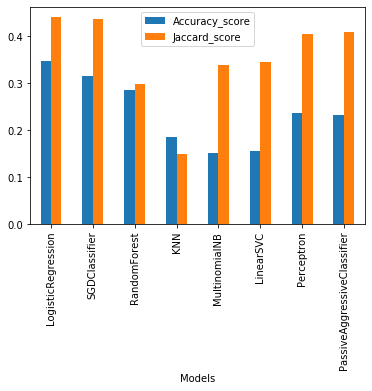

<Figure size 2160x1080 with 0 Axes>

In [40]:
score_AccuracyJaccard_df = pd.DataFrame({
    'Models': ['LogisticRegression', 'SGDClassifier',
               'RandomForest', 'KNN', 'MultinomialNB', 'LinearSVC',
               'Perceptron', 'PassiveAggressiveClassifier'],
    'Accuracy_score': [accuracy_score_logr,
                       accuracy_score_sgd,
                       accuracy_score_rand,
                       accuracy_score_knn,
                       accuracy_score_mnb,
                       accuracy_score_lsvc,
                       accuracy_score_prpt,
                       accuracy_score_pac],
    'Jaccard_score': [jaccard_score_logr,
                      jaccard_score_sgd,
                      jaccard_score_rand,
                      jaccard_score_knn,
                      jaccard_score_mnb,
                      jaccard_score_lsvc,
                      jaccard_score_prpt,
                      jaccard_score_pac]})
ax = plt.gca()
score_AccuracyJaccard_df.plot(kind='bar', x='Models',
                              y=['Accuracy_score', 'Jaccard_score'], ax=ax)
plt.figure(figsize=(30, 15))
plt.show()

###  Test sur formulaire :

On constate que le modèle de LogisticRegression a le meilleur score, donc nous allons tester notre prédiction à partir de ce modèle

In [19]:
# Sauvegarder le modèle sur le disque :
pickle.dump(sgd_linear_clf_fit, open('models/model.pkl', 'wb'))

#### Prediction avec LogisticRegression :

In [30]:
# Loading model to compare the results
model = pickle.load(open('models/model.pkl', 'rb'))
# model = log_reg_clf_fit
textInput = " langage datetime c# java python javascript the c definitive guide to form based"
# textInput = data_preprocess[(data_preprocess['Id'] == 9)]['BodyTitle']
most_freq_words = top1000words_exp
most_freq_tags = top100tags_exp

4:80: E501 line too long (94 > 79 characters)


In [31]:
print(textInput)

 langage datetime c# java python javascript the c definitive guide to form based


In [32]:
tagslist = predictTag(model, textInput, top1000words_exp, top100tags_exp)
print('les tags proposées sont : ', tagslist)

les tags proposées sont :  ['python']
